# Chapter 4 | Natural Language Processing, Transformers, Huggingface
> A New Library, New Model Architectures, And Natural Language Data

> Checkout this notebook in [colab](https://colab.research.google.com/github/nglillywhite/blog/blob/main/posts/2023-01-08-Fastai%20Chapter%204.ipynb)

This week focuses on building models with interact with natural language which is very different from images or structured tabular data. Jeremy starts off discussing some model architectures (some of which he pioneered with collaborators) like 'ULMFit', 'Transformers', and Recurrent Neural Nets (RNNs) which are often seen in the news headlines as being significant. This week will also use huggingface, which is another library from fastai but is seemingly the best library as of writing this for working with language. We're going to dive into tokenising and other natural language specific problems.

## Lecture Content
### US Patent Phrase Matching

We're working with the [US Patent Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching) Kaggle Competition data for this lesson lecture, I've just visited the page and downloaded the dataset into my local data path but you can of course use the kaggle APIs.

This competition in particular is about comparing two short phrases and whether they are similar to each other based on which patent class they were used with. Scores of 1 being identical and 0 meaning they are different. The scores are represented in a set of 0, 0.25, 0.5, and 1 which acts like a classification problem rather than regression because they're distinct instead of smooth.

Jeremy starts by proposing that we can feed this into our model successfully by representing the data as "TEXT1: abatement; TEXT2: eliminating process" of which we then pick a distinct category from the above. To my understand this relates to the 'anchors' and 'target' in this dataset which we'll look at below.

### EDA of Patent Data

In [1]:
from pathlib import Path
from fastai.vision.all import *

data_path = Path("../data/us-patent-phrase-to-matching/")

In [2]:
data_path.ls()

(#2) [Path('../data/us-patent-phrase-to-matching/test.csv'),Path('../data/us-patent-phrase-to-matching/train.csv')]

In [3]:
import pandas as pd

df = pd.read_csv(data_path / "train.csv")

df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [4]:
df.describe(include="object")

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


From having a quick look at a data sample and a description of the dataframe itself, there simply aren't that many unique contexts or anchors, and the anchor 'component composite coating' turns up 152 times which seems like a lot our of the 733 total.

Lets now build our first feature which will be the 'input' feature. We'll structure this feature as we noted earlier in the TEXT1: ...; TEXT2:...; format

In [5]:
df['input'] = "TEXT1: " + df.context + "; TEXT2: " + df.target + "; ANC1: " + df.anchor

df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement
1            TEXT1: A47; TEXT2: act of abating; ANC1: abatement
2           TEXT1: A47; TEXT2: active catalyst; ANC1: abatement
3       TEXT1: A47; TEXT2: eliminating process; ANC1: abatement
4             TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

Ok this looks great, I'm already a bit confused since the dataset has described the df.context as the CPC classification subject and the anchor and target being the first and second phrase respectively whereas Jeremy has put the context as the first text. Nonethless, I'm sure the naming of each of these features is sort of irrelevant as long as its consistent. If I called it 'text1' or 'feature1' or 'f1' it wouldn't matter to the model, its all matrices in the end.


### Tokenisation and Numericalisation
Lets now take on the first two new topics which are tokenisation and numericalisation, this is the act of transforming our words into tokens which represent unique examples of words and turning those tokens into numbers which we can then matrix multiply and then convert back after the fact. We're going to use huggingface's datasets library and use their "Dataset" class which overlaps a class name with fastai and pytorch.

In [6]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)

ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

Ok not learning a huge amount from the output but it at least lets us know what our features are and how many rows we have.

In [7]:
doc(Dataset)

Doesn't tell me a whole lot about the class or purpose but lets move on for now.

An important thing to note is that particular tokenisers are used for particular models and if you want to use a pre-trained model, you have to make sure you have the same tokeniser (and numericalisation process) otherwise you aren't representing the language the same way as the model was trained. Lets grab a model and get to work

In [8]:
model_name = "microsoft/deberta-v3-xsmall"

Now we're pulling from the [huggingface database](https://huggingface.co/models) of models, many of which are trained for particular tasks. Feel free to have a browse and search for models you might be interested in!

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokeniser = AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\transformers\convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
tokeniser

PreTrainedTokenizerFast(name_or_path='microsoft/deberta-v3-xsmall', vocab_size=128000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Ok some interesting output here, looks like there's a bunch of settings on tokenisers that represent special handling of things like spaces or sizing a sentence with padding and separators etc.

In [11]:
tokeniser.tokenize("Jeremy is the GOAT")

['▁Jeremy', '▁is', '▁the', '▁GOAT']

Ok awesome there are my tokens, Jeremy also notes that uncommon words will be split up and the start of words is represented by an underscore.

In [12]:
tokeniser.tokenize("I suffered a flabbergasting conniption when I saw the spelling of ornithorhynchus anatinus.")

['▁I',
 '▁suffered',
 '▁a',
 '▁flab',
 'berg',
 'as',
 'ting',
 '▁con',
 'ni',
 'ption',
 '▁when',
 '▁I',
 '▁saw',
 '▁the',
 '▁spelling',
 '▁of',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

ok cool, we can see the tokeniser will split up some bigger words but not others, ie conniption but not spelling. There's also underscores and other 'encodings' being placed on the writing and words. Lets now write a function that will take in our input column and tokenise it for us

In [13]:
def tokenise_function(x): return tokeniser(x['input'])

Looks like we can also call the tokeniser directly which is interesting

In [14]:
tokeniser("what")

{'input_ids': [1, 339, 2], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

In [15]:
tokeniser("Homer")

{'input_ids': [1, 21811, 2], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

However its returning different values than our tokenize() object method, we can look at this later.

Lets get back to tokenising our dataset

In [16]:
tokeniser_dataset = ds.map(tokenise_function, batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [17]:
row = tokeniser_dataset[0]

row["input"], row["input_ids"]

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

Cool, we've got the text we've fed in and a matching set of tokens that have been numericalised. We can always investigate what these numericalised values mean by referencing the 'vocabulary' or 'vocab' of the model via the vocab attribute.

In [18]:
tokeniser.vocab["▁Procrastination"]

111284

I'm afraid of 111284, don't ask why...

In [19]:
tokeniser.vocab["▁abatement"]

47284

We can see 47284 turn up twice in our tokenised and numericalised row above since its there twice in our input row, awesome.

Transformers always assume you have a column called "labels" with your labels, for us its 'score' at the moment so lets rename our column

In [20]:
tokeniser_dataset = tokeniser_dataset.rename_column(original_column_name="score", new_column_name="labels")

In [21]:
tokeniser_dataset

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

### Creating Validation & Test Sets

Lets grab our test dataset

In [22]:
evaluation_df = pd.read_csv(data_path / "test.csv")
evaluation_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


Now before we decide on our validation set data, lets quickly work through the underfitting and overfitting examples.

### Underfitting & Overfitting

This is the idea that you can not train enough on your training data and not learn the relationships within your data, or train too much and end up 'memorising' the data and/or noise rather than learning the underlying relationships, which when tested against new data will perform poorly. This can also be framed as the bias-variance tradeoff, there is more nuance to this but this is generally indicative of the kind of behaviour we're going to describe. I find under-fitting (not learning enough) and over-fitting (memorising rather than understanding, and generalising poorly) as more intuitive understandings.

Similar to previous lessons, we're going to pretend the underlying data is some magical quadratic that we'll add some noise to and play with some parameters.

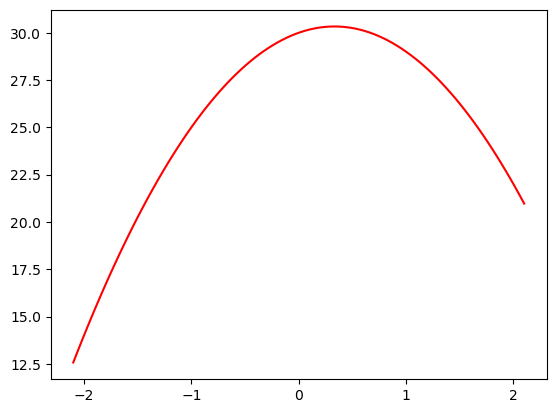

In [23]:
def f(x): return -3*x**2 + 2*x + 30

def plot_function(f, min=-2.1, max=2.1, color="r"):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

plot_function(f)

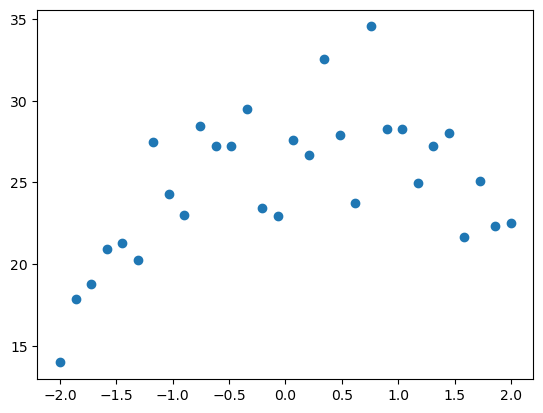

In [24]:
# This simply replicates the same behaviour for each run of this notebook (and your colab if you're following along)
from numpy.random import normal, seed, uniform
np.random.seed(42)

def noise(x,scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x, add)

x = np.linspace(-2,2, num=30)[:,None]
y = add_noise(f(x), 0.1, 1.2)
plt.scatter(x,y)

These should look familiar from both Jeremy's notebook & the previous lessons where we create some quadratics and add noise, lets now show some over and underfitting of these data points.

As Jeremy mentions, we're going to create a function that fits polynomials of a given degree, a line being degree 1, a quadratic is degree 2, a cubic is degree 3, and so on. He recommends watching [this video](https://www.youtube.com/watch?v=ffLLmV4mZwU) as a refresher if this jargon is foreign to you. I don't remember the degrees of a polynomial so I'm going to watch this video now before I continue.

Ok, nice little watch, how long I retain this we'll see but I'm feeling good about polynomials being chains of terms with co-efficients and variables, thanks mathantics!

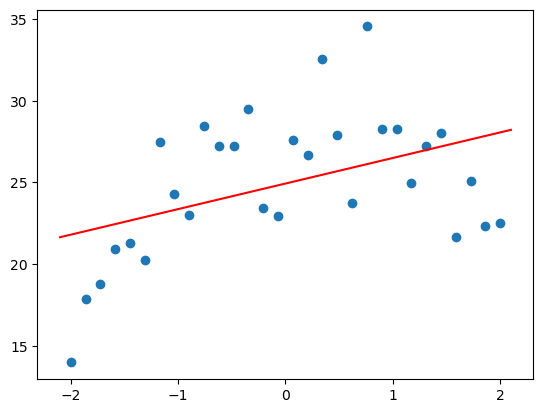

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x,y)
    plt.scatter(x,y)
    plot_function(model.predict)
    

plot_poly(1)

Ok so looks like an "under" fit situation here, we're not really understanding the relationship between the data points and I don't think we understand how this data is shaped. Lets look at 10 degrees.

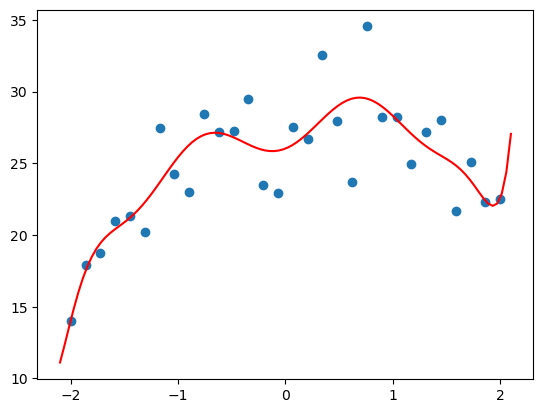

In [26]:
plot_poly(10)

Ok now we're "over" fitting as we're simply memorising and far too sensitive to the noise in the data, especially at the end where we completely invert the direction of the line and go back up, this is totally wrong!

Lets now get the right amount of degrees, which is 2 and also plot the underlying true function

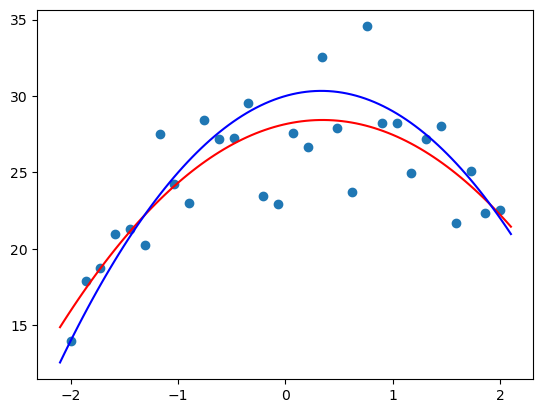

In [27]:
plot_poly(2)
plot_function(f, color="b")

Hey thats pretty cool, we're not far off here, we're properly understanding the relationship and estimating correctly the shape of the 'true' function. Of course we're off slightly since there's noise in the data but the approximation is excitingly close.

### Recognising Over/Under Fitting

This takes us back to our validation set, which is the tool we use to figure out if we're getting this relationship between under and over fitting in the sweet spot. This is a hold out of data from training that we use to see our model might generalise on 'unseen' data, we don't want to use the test set as thats only used at the very end of the process to check on 'unseen' unseen data. The problem arises from running many iterations and tests on your validation set, you're probably going to come across good random variables/parameters as well as slowly leak to your training process, what data is in the validation set which defeats the purpose of trying to see how well your model generalises on data it doesn't know from training. So we want to make decisions on a good validation set and hold out our test set for the very end of the process.

Transformers uses a "DatasetDict" for holding the training and validation sets. In this scenario we can simply slice apart a random 25% of our dataset for validation, but once again I'll post [Rachel Thomas's awesome writeup](https://www.fast.ai/posts/2017-11-13-validation-sets.html) on exactly this question of how to make a good validation set.

In [28]:
dds = tokeniser_dataset.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

Transformers uses the language of our 'validation' set being called 'test' set which actually isn't all that uncommon but we're being specific here so don't get confused between the two. Remember validation for informing our training process (but not used in the training process to learn from) and the final test set being an 'unseen' unseen set to holdout.

Lets modify our test dataset to include the same 'input' column that we made for our train dataset

In [29]:
evaluation_df["input"] = 'TEXT1: ' + evaluation_df.context + '; TEXT2: ' + evaluation_df.target + '; ANC1: ' + evaluation_df.anchor
evaluation_ds = Dataset.from_pandas(evaluation_df).map(tokenise_function,batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

### Metrics & Correlation

As we worked through in our previous lessons, metrics and loss functions are measurements that we're able to optimise and very efficiently so. [Rachel Thomas has another awesome post about the problems with this efficiency](https://www.fast.ai/posts/2019-09-24-metrics.html), its definitely worth a read.

An important metric to understand is correlation, how closely or inversely to particular pairs of features rise or fall from each other when the one is changed, there are a couple of cool methods from sklearn that we can use to check out this metric; we can also plot it nicely. Lets bring down the California Housing dataset that comes with sklearn and work with that for starters.

In [30]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
housing = housing["data"].join(housing["target"]).sample(1000, random_state=42)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20046,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,0.47700
3024,2.5313,30.0,5.039384,1.193493,1565.0,2.679795,35.14,-119.46,0.45800
15663,3.4801,52.0,3.977155,1.185877,1310.0,1.360332,37.80,-122.44,5.00001
20484,5.7376,17.0,6.163636,1.020202,1705.0,3.444444,34.28,-118.72,2.18600
9814,3.7250,34.0,5.492991,1.028037,1063.0,2.483645,36.62,-121.93,2.78000


Ok so we can see some general data about housing in California, lets checkout the correlations with numpy.

In [31]:
np.set_printoptions(precision=2, suppress=True)
np.corrcoef(housing,rowvar=False)

array([[ 1.  , -0.1 ,  0.51, -0.07, -0.  , -0.02, -0.1 ,  0.  ,  0.69],
       [-0.1 ,  1.  , -0.18, -0.11, -0.33,  0.03,  0.03, -0.13,  0.1 ],
       [ 0.51, -0.18,  1.  ,  0.67, -0.06, -0.01,  0.13, -0.05,  0.26],
       [-0.07, -0.11,  0.67,  1.  , -0.04, -0.08,  0.1 , -0.  , -0.04],
       [-0.  , -0.33, -0.06, -0.04,  1.  ,  0.15, -0.11,  0.11, -0.03],
       [-0.02,  0.03, -0.01, -0.08,  0.15,  1.  , -0.17,  0.19, -0.26],
       [-0.1 ,  0.03,  0.13,  0.1 , -0.11, -0.17,  1.  , -0.92, -0.14],
       [ 0.  , -0.13, -0.05, -0.  ,  0.11,  0.19, -0.92,  1.  , -0.06],
       [ 0.69,  0.1 ,  0.26, -0.04, -0.03, -0.26, -0.14, -0.06,  1.  ]])

Here are another few quick ways to get the same matrix and visualise it, natively with pandas, with matplotlib, and seaborn. You can customise these but I think these are nice starts to access the same data

In [32]:
housing.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.099337,0.509533,-0.068371,-0.003260,-0.021351,-0.099966,0.002959,0.688787
HouseAge,-0.099337,1.000000,-0.184928,-0.108935,-0.333983,0.026371,0.032930,-0.126596,0.099851
AveRooms,0.509533,-0.184928,1.000000,0.666193,-0.055821,-0.009879,0.127917,-0.050235,0.263954
AveBedrms,-0.068371,-0.108935,0.666193,1.000000,-0.041664,-0.082372,0.102355,-0.000441,-0.037114
Population,-0.003260,-0.333983,-0.055821,-0.041664,1.000000,0.152235,-0.110230,0.105513,-0.032120
AveOccup,-0.021351,0.026371,-0.009879,-0.082372,0.152235,1.000000,-0.171743,0.193559,-0.258307
Latitude,-0.099966,0.032930,0.127917,0.102355,-0.110230,-0.171743,1.000000,-0.919229,-0.136581
Longitude,0.002959,-0.126596,-0.050235,-0.000441,0.105513,0.193559,-0.919229,1.000000,-0.063320
MedHouseVal,0.688787,0.099851,0.263954,-0.037114,-0.032120,-0.258307,-0.136581,-0.063320,1.000000


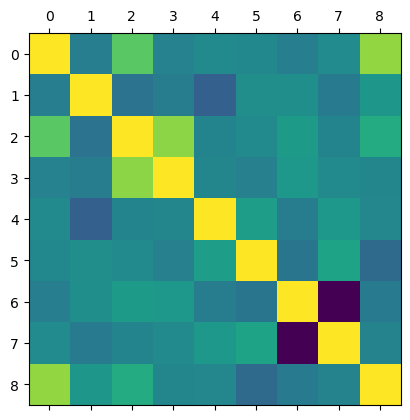

In [33]:
plt.matshow(housing.corr())
plt.show()

<AxesSubplot: >

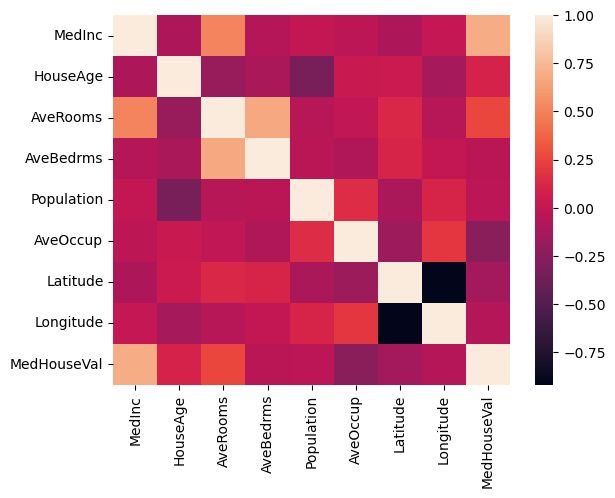

In [34]:
import seaborn as sns

corr = housing.corr()
sns.heatmap(corr)

Awesome, we can see that most of the features are fairly uncorrelated but there are some that are highly correlated, for example MedHouseVal and MedInc which are the value of the house and income respectively, lets look into this value specifically

In [35]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.69],
       [0.69, 1.  ]])

0.69 is a fairly positive value, lets write a small function to give us back the pair values that we seek.

In [36]:
def correlation(x,y): return np.corrcoef(x,y)[0][1]

correlation(housing.MedInc, housing.MedHouseVal)

0.6887874432146511

Now we can write a small function to plot these pairs and their correlation. Just before we do that, lets look at all the features plotted against each other with seaborns pairplot which can help you at a glance spot some of these nicely matched relationships

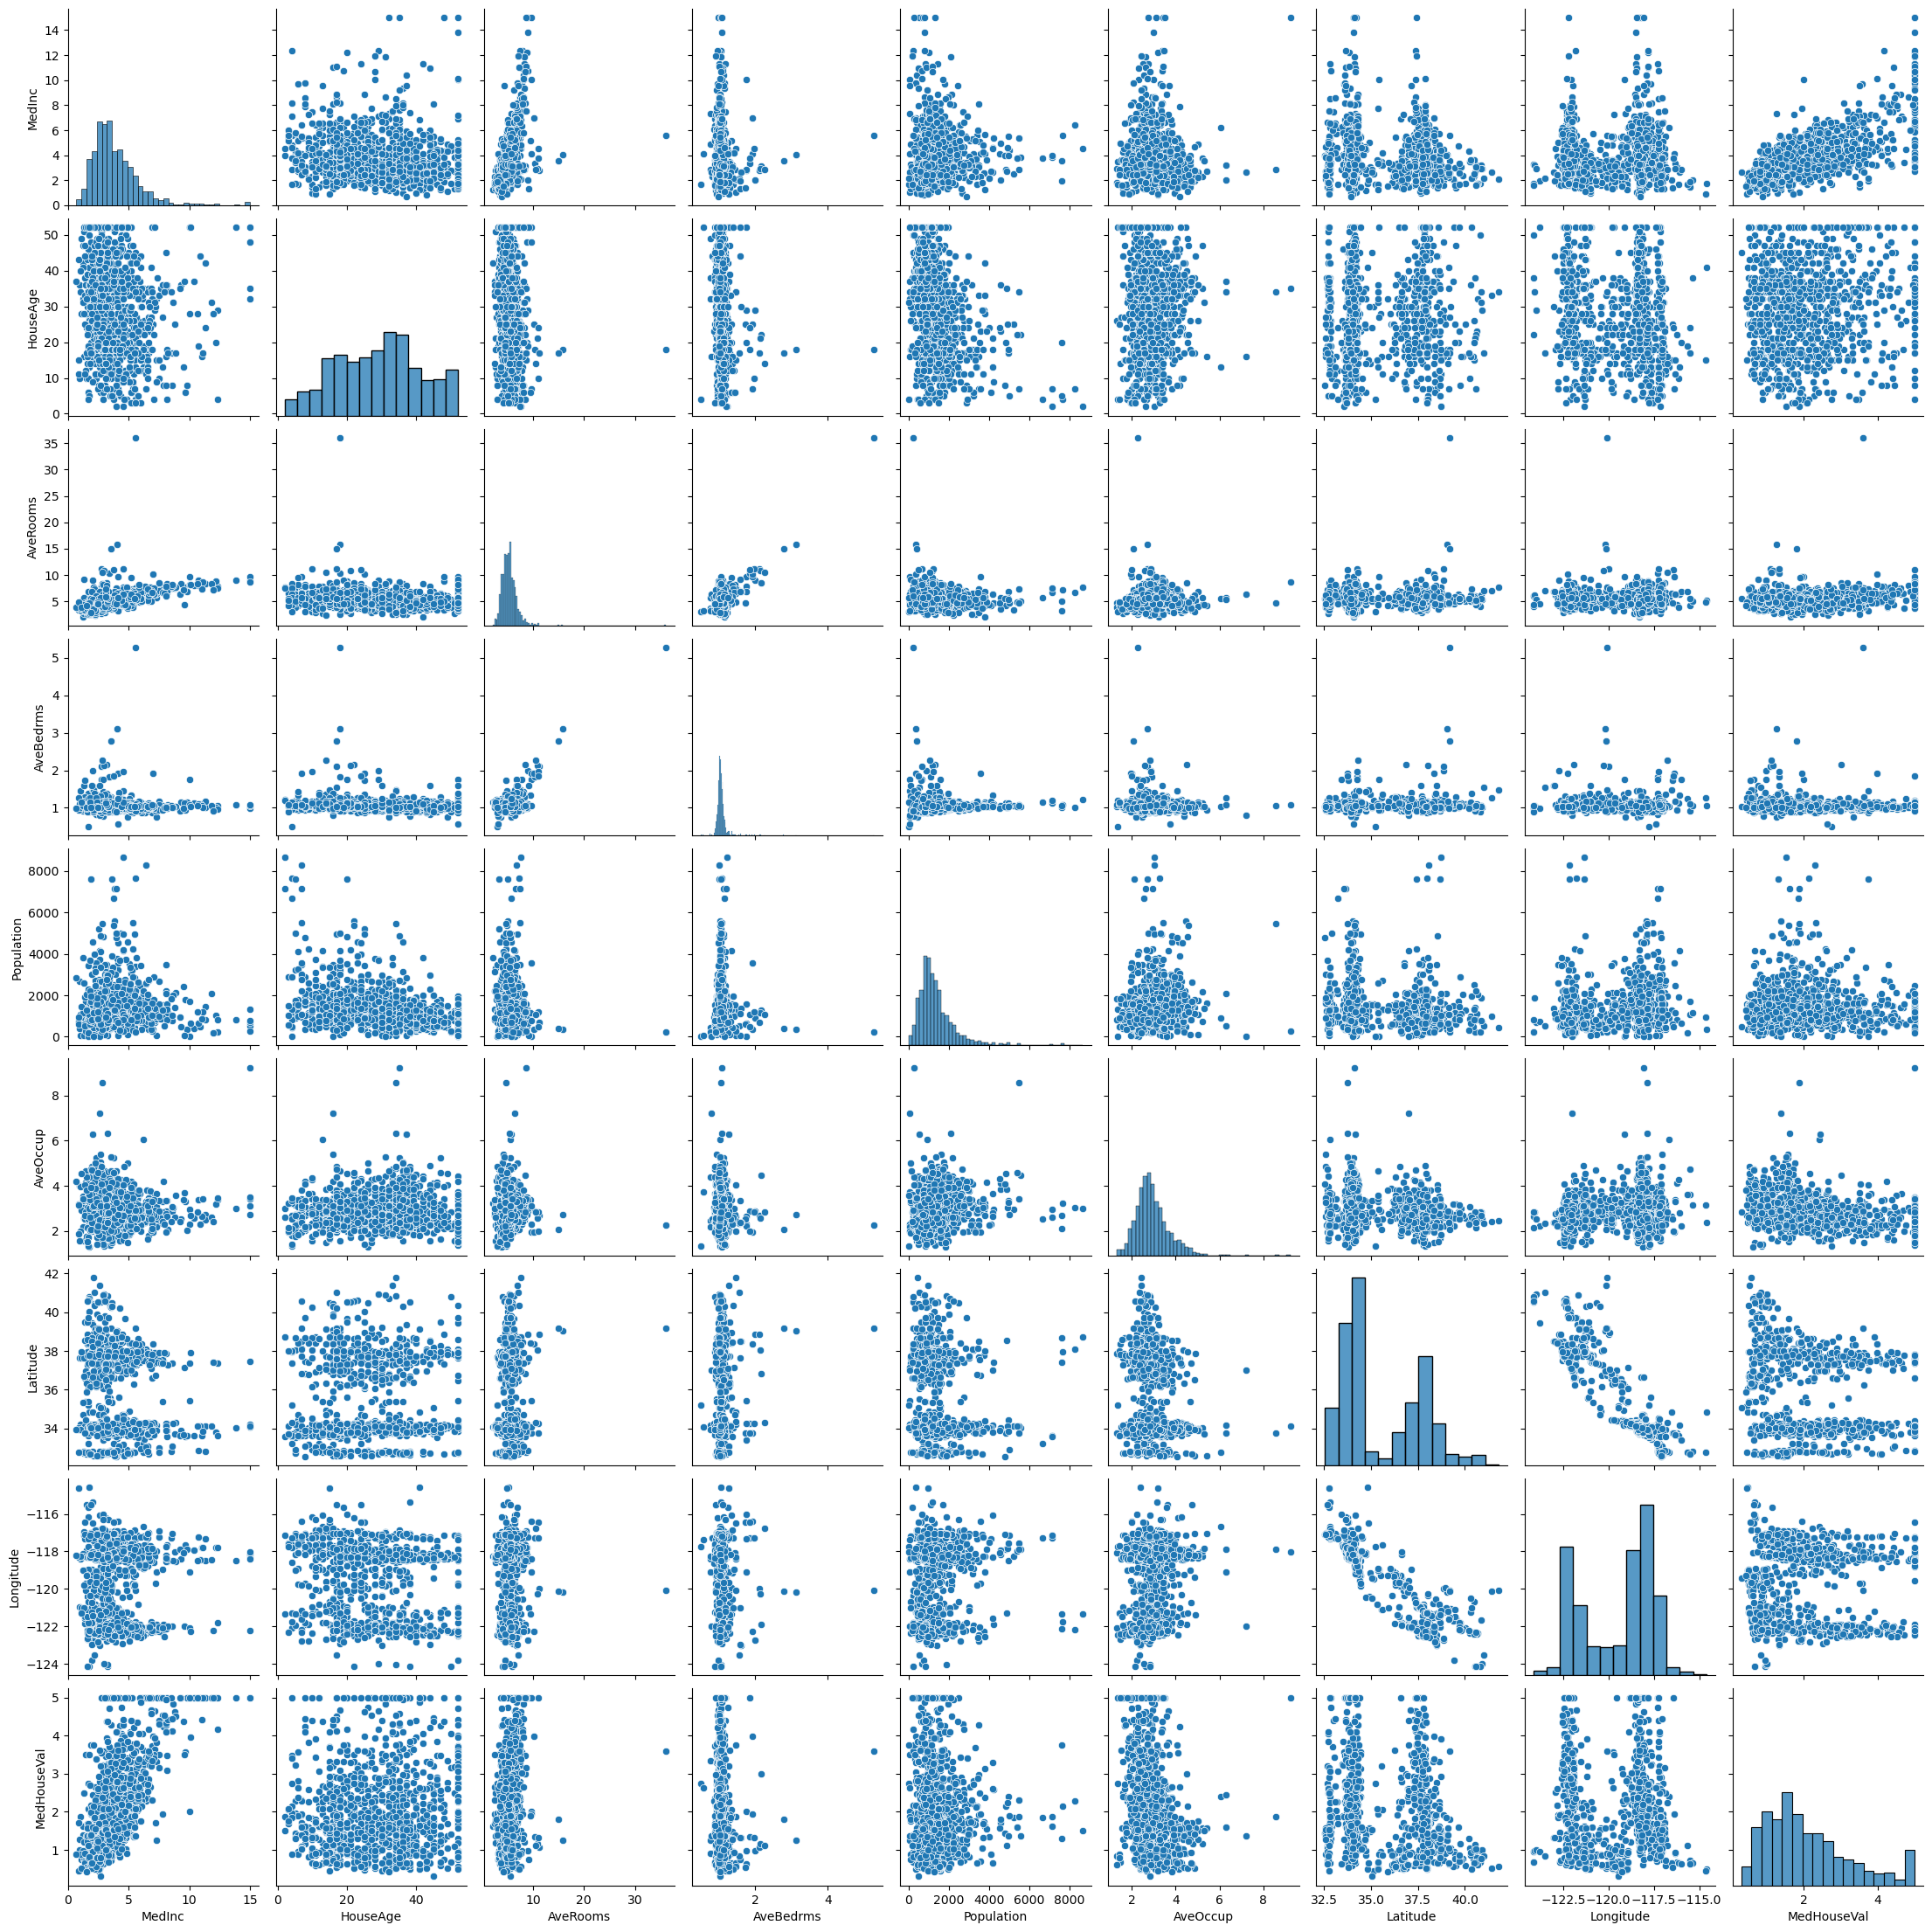

In [37]:
sns.pairplot(housing)

How cool is that, we get a whole bunch of histograms along the diagonal and can see all the other relationships plotted around, however if we want to dig into just one of them, we want to plot it specifically which we'll make a helper method to do for us.

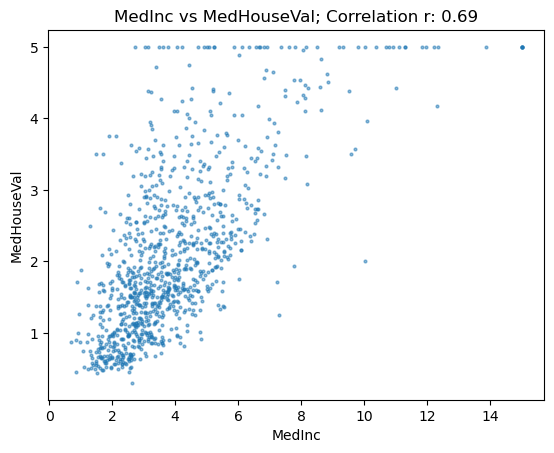

In [38]:
def show_correlation(df, a, b):
    x,y = df[a], df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.xlabel(a)
    plt.ylabel(b)
    plt.title(f"{a} vs {b}; Correlation r: {correlation(x,y):.2f}")
    plt.show()
    
show_correlation(housing, "MedInc", "MedHouseVal")

We can see that a bunch of MedHouseVal's have been clipped at 5 and whilst this is a higher correlation value, there's still quite a wide spread in the data, lets look at more

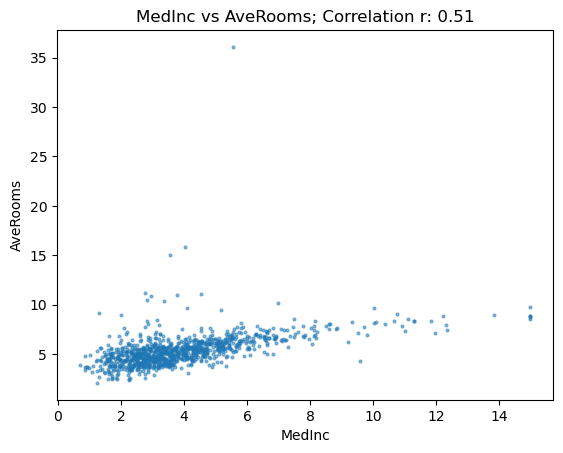

In [39]:
show_correlation(housing, "MedInc", "AveRooms")

Ok this looks way tighter and more closely matched but we've got literally only a value or two as extreme outliers which I suspect are misclassed somehow as Jeremy mentions. Maybe this is a sharehouse or apartment building instead of considering them as different households. Lets filter out the outliers and see what happens to our correlation value.

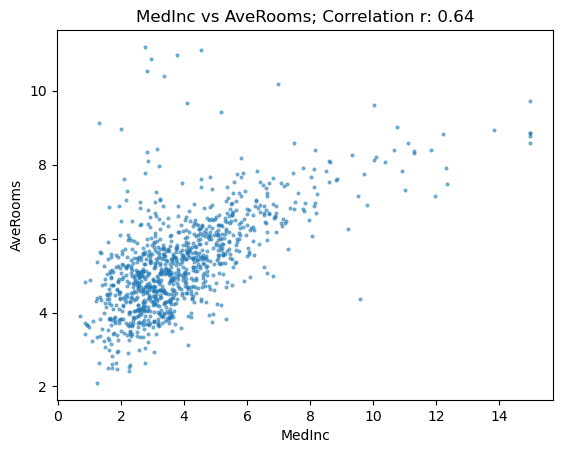

In [40]:
subset = housing[housing.AveRooms<13]
show_correlation(subset, "MedInc", "AveRooms")

Our value shoots up to 64 and looks highly correlated and tightly plotted rather than spread out. Lets look at another.

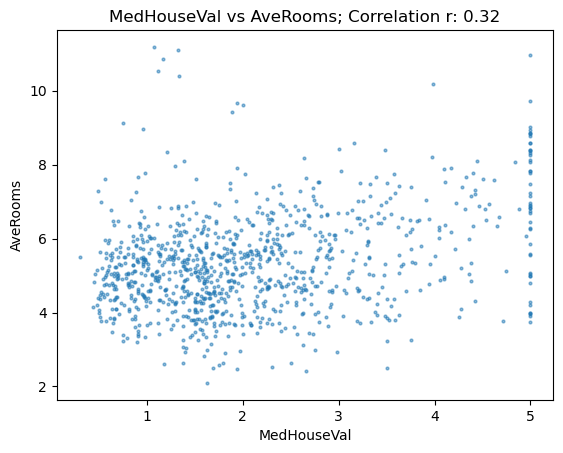

In [41]:
show_correlation(subset, "MedHouseVal", "AveRooms")

This looks pretty messy and has a pretty weak correlation if any, there's also that MedHouseVal clipping again.

Lets get back to our Transformers


### Transformer Metrics

Transformers expect metrics to be returned as a dictionary, lets create a function to meet this requirement. In our competition we're using the '[Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)'

In [42]:
def correlation_d(eval_pred): return {'pearson':correlation(*eval_pred)}

### Training the Transformer

Similar to our fastai learner object we need to create a "Trainer" of which we set the batch size, epochs, learning rate, and other parameters as we would like to manage the training process.

Seems like there's lots of crossover in terms of techniques and principles, but with some synonyms and similar words used in the same place, ie 'learner' is to 'trainer'.

In [43]:
#| echo: false

import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [44]:
from transformers import TrainingArguments, Trainer

batch_size = 20
epochs = 2
learning_rate = 8e-5

args = TrainingArguments("outputs",
                        learning_rate=learning_rate,
                        warmup_ratio=0.1,
                        lr_scheduler_type="cosine",
                        fp16=True,
                        evaluation_strategy="epoch",
                        per_device_train_batch_size=batch_size,
                        per_device_eval_batch_size=batch_size*2,
                        num_train_epochs=epochs,
                        weight_decay=0.01,
                        report_to="none")

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
trainer = Trainer(model,
                  args, train_dataset=dds["train"],
                  eval_dataset=dds["test"],
                 tokenizer=tokeniser, compute_metrics=correlation_d)

Some weights of the model checkpoint at microsoft/deberta-v3-xsmall were not used when initializing DebertaV2ForSequenceClassification: ['deberta.embeddings.word_embeddings._weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializ

In [45]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, id, context, input, anchor. If target, id, context, input, anchor are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\Nick\Anaconda3\envs\fastai\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 27354
  Num Epochs = 2
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 2736
  Number of trainable parameters = 70830337
You're using a DebertaV2TokenizerFast tokenizer. Please

Epoch,Training Loss,Validation Loss,Pearson
1,0.033400,0.030246,0.776644
2,0.021300,0.025342,0.801732


Saving model checkpoint to outputs\checkpoint-500
Configuration saved in outputs\checkpoint-500\config.json
Model weights saved in outputs\checkpoint-500\pytorch_model.bin
tokenizer config file saved in outputs\checkpoint-500\tokenizer_config.json
Special tokens file saved in outputs\checkpoint-500\special_tokens_map.json
Saving model checkpoint to outputs\checkpoint-1000
Configuration saved in outputs\checkpoint-1000\config.json
Model weights saved in outputs\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in outputs\checkpoint-1000\tokenizer_config.json
Special tokens file saved in outputs\checkpoint-1000\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, id, context, input, anchor. If target, id, context, input, anchor are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evalu

TrainOutput(global_step=2736, training_loss=0.03071680386164035, metrics={'train_runtime': 767.9404, 'train_samples_per_second': 71.24, 'train_steps_per_second': 3.563, 'total_flos': 160758836273364.0, 'train_loss': 0.03071680386164035, 'epoch': 2.0})

Holy Batman there's a lot more logging going on for transformers, but I'm sure this would be useful as soon as you've got to debug or solve some problems, regardless our loss is going down and our coefficient is going up. Lets make some predictions of which we could submit if we wanted to compete

In [46]:
preds = trainer.predict(evaluation_ds).predictions.astype(float)
preds[:5]

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, id, context, input, anchor. If target, id, context, input, anchor are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36
  Batch size = 40


array([[0.5 ],
       [0.7 ],
       [0.22],
       [0.29],
       [0.05]])

In [47]:
preds.max(), preds.min()

(1.09765625, -0.007724761962890625)

We've got predictions above 1 and below 0 which are impossible so lets clip them. I think in the future, we're better off using sigmoid which Jeremy seems to allude to but thats for another day.

In [48]:
preds = np.clip(preds, 0, 1)

In [49]:
preds.max(), preds.min()

(1.0, 0.0)

Awesome, nicely limited.

OK we made it through the notebook, this was really familiar as Jeremy noted and didn't feel too new. The experience of finding a great model to transfer learn, kickoff the training loop and look at the loss metrics is a comfortable space to be. Other than needing to take in tokenisation and numericalisation, this all felt pretty friendly. Its fascinating how the same concepts, behaviours, mindset, and generally the code can be re-used to predict shark species from images or classify documents from text. Its kind of mind blowing!

I was maybe expecting more of a discussion on the structure of transformers and why they're unique compared to other architectures like ULMFit which Jeremy mentioned but maybe thats for a later lesson, its also something that I'm obviously free to research myself. Maybe another blog to write once I'm further through the course and come back to, nonetheless lets crack out the textbook.

## Book Content

### Self-Supervised Learning

Self Supervision is the process of learning from data without explicit labels, in the example from fastbook, its noted that the chapter introduction model has read a bunch of prior words from a document and attempts to predict the next word. This process doesn't have explicit labels but the model is learning these 'labels' from the actual training data itself. We've worked through a normal supervised task above via transfer learning and some labelled data and this is explicitly different from self-supervision. [Here is an example of self-supervision for a vision task](https://www.fast.ai/posts/2020-01-13-self_supervised.html) that Jeremy notes in the book, I'm going to reference this post to describe some of the self supervision topics we come across. From this blog, the self supervision description is 'train a model using labels that are naturally part of the input data, rather than requiring separate external labels.' As usual I couldn't say it better.

Ok so our goal is to run this self-supervised training process to discover some 'innate' weights that are useful, we then transfer learn to our new task and fine tune on the original intended goal. ULMFit once again turns up as a great example of this process, I think it would be fun to re-create this paper down the track, might be a fun series to do in general.

#### Pre-Text and Down-Stream Tasks

The 'pre-training' task that discovers these innate weights I was paraphrasing before is called the 'pretext' task, the fine tuning tasks intended for our original goal are called 'downstream' tasks. Some of the vision pretext tasks mentioned in the computer vision example are colorisation, placing subsets of an image in the correct location, placing frames in the right order, in-painting where you fill in a missing portion of an image, and classifying corrupted images. Have a look at the linked post above for visual examples of these tasks.

Naturally deciding on these pretext tasks is important and Jeremy discusses how you want to decide some process where 'if solved' it would provide some insight into the original task you're trying to complete.

#### Consistency Loss

Jeremy discusses a topic called "consistency loss" or "noise contrastive estimation" in computer vision. In a lot of these pretext tasks, you have some original input, you then muck with it, make it greyscale for example in the colorisation task, and then ask the model to predict the colors and compare it to the original input. For these tasks you want the original input and the 'pre-texted' image to match as you're just trying to re-construct the original input, you'd also hope that the same original input that is augmented in different batches for different amounts still produces the same output since the augmentations are from the same input and are only different in terms of the randomness applied to the colorisation or patching or rotation etc. Apparently you can add to the loss function an penalising term that punishes 'getting different answers for different versions of the same data.' From Jeremy's post he says they used 1000x less labeled data and smashed the previous state of the art, apparently you can add this to any pretext task and since its so effective, why wouldn't you?!

There's lots of awesome papers in this post, as I mentioned before when I was thinking of re-creating ULMFit sometime, I think doing a write up on self-supervision and this consistency loss would be fun and interesting.

### Tokenisation With Fastai

Ok we've understood tokenisation and numericalisation from working through the huggingface notebook so I won't rehash these topics here but the book provides a great guide on how to use the fastai library and build some tokenisers so I'm keen to see how its different from huggingface, lets get stuck in.

In [5]:
from fastai.text.all import *

path = untar_data(URLs.IMDB)

In [51]:
files = get_text_files(path, folders = ["train", "test", "unsup"])

In [52]:
txt = files[42].open().read(); txt[:500]

"I wanted to like this movie. I really, really did. I was so excited when I saw the preview, which scared the hell out of me. But when I saw the actual film, I was disappointed. The acting is stilted, and the attempts at comedy are woefully out of place and forced. And I'm sorry, but a boy being chased by a turd in a bedpan is not funny or scary, it's just stupid. I grew up on the Bell Witch legend, so I know quite a bit about it. A lot of facts in the movie are right on target, but this film sho"

Ok this review is hilarious, "a boy being chased by a turd" is apparently a real scene in this movie and dissapointingly the reviewer said it wasn't funny or scary, what a shame, so much potential.

As of when the book was written, spaCY is the english word tokeniser used which is apparently driven by a sophisticated rules engine containing special rules for URLs, special english words etc. Rather than calling spaCY directly with the 'SpacyTokenizer', we're going to use the fastai 'WordTokenizer' which will point to fastai's current default tokeniser. I wonder if there's an obvious way to inspect this object and see what fastai is currently using as of now (15th Jan 23) when I'm writing this.

In [53]:
tokeniser = WordTokenizer()
tokens = first(tokeniser([txt]))
print(coll_repr(tokens, 30))

(#224) ['I','wanted','to','like','this','movie','.','I','really',',','really','did','.','I','was','so','excited','when','I','saw','the','preview',',','which','scared','the','hell','out','of','me'...]


As we saw in the previous tokenisation task from the lecture, we mainly get all the words split out with some special cases handled, uppercase, and fullstops modified. As noted in the book, there are so many subtle rules of langauge that are implicit and explicit in how we write, its extremely fluid and complex but there are underlying principles in the structure that we want noted and specified, like names needing uppercase, or a word at the start of the sentence vs in the middle of a sentence having different meanings.

In [54]:
doc(coll_repr)

coll_repr is a cool way to show a python collection as well as its size instead of wrapping all the boilerplate calls to structure it, it also uses the fastcore 'L' class which is python lists on steroids, super useful stuff!

In [55]:
tokeniser

Looks like SpacyTokenizer is still king of the throne, I wonder if and when this will be changed and for what reason!

In [56]:
fastai_tokeniser = Tokenizer(tokeniser)
print(coll_repr(fastai_tokeniser(txt), 30))

(#239) ['xxbos','i','wanted','to','like','this','movie','.','i','really',',','really','did','.','i','was','so','excited','when','i','saw','the','preview',',','which','scared','the','hell','out','of'...]


Ok there's some extra functionality being wrapped ontop here, as noted in the book, in particular the 'xxbos' token which means the start of a new text, 'BOS' in the broader NLP space is an acronym that means "beginning of stream." Supposedly this helps the model realise that it needs to forget what it was thinking about and focus on the upcoming words as this is a new document/text. This tokenisation process definitely seems to standardise and structure any text into an explicit version where a lot of implicit rules of written language are explicitly expressed as tokens. An example being the start of a sentence which we as people have no need to signify other than a capital letter and a full stop prior but are extremely valuable tokens for a model to explicitly pickup.

Some other tokens of significance are 'xxmaj' meaning the next word starts uppercase and by default all the text is set to lowercase, 'xxunk' meaning the next word is unknown. We can also checkout the rules that are used and I assume that this list can be modified or added to if need be. We can always inspect these rules with the doc() function or ?? jupyter magic calls as we've done throughout the previous couple of chapters.

In [57]:
defaults.text_proc_rules

[<function fastai.text.core.fix_html(x)>,
 <function fastai.text.core.replace_rep(t)>,
 <function fastai.text.core.replace_wrep(t)>,
 <function fastai.text.core.spec_add_spaces(t)>,
 <function fastai.text.core.rm_useless_spaces(t)>,
 <function fastai.text.core.replace_all_caps(t)>,
 <function fastai.text.core.replace_maj(t)>,
 <function fastai.text.core.lowercase(t, add_bos=True, add_eos=False)>]

In [58]:
doc(replace_rep)

In [59]:
replace_rep??

Signature: replace_rep(t)
Source:   
def replace_rep(t):
    "Replace repetitions at the character level: cccc -- TK_REP 4 c"
    def _replace_rep(m):
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    return _re_rep.sub(_replace_rep, t)
File:      c:\users\nick\anaconda3\envs\fastai\lib\site-packages\fastai\text\core.py
Type:      function


### Subword Tokenisation

For a language like english where most, if not all words are separated by a space, this method of tokenisation where we splitup mostly by word is quite effective, however in languages like Mandarin, Hungarian, Turkish, Japanese, etc that don't have the same rules in terms of spaces or joining multiple words together, different techniques are required. One of those is subword tokenisation which is done by the following steps:

 1. Analyse a corpus of documents and find the most commonly occurring groups of letters, this is your vocab
 2. Tokenise the corpus using this vocab of subword units
 
This honestly did not occur to me as significant in terms of language differences regarding structure and moreso seemed important for compound words in the english language or words derived from latin where multiple latin roots are joined together. An example being animal taxonomy like we worked through in the lecture. Either way lets work through a quick example with Jeremy and the book.

In [60]:
txts = L(o.open().read() for o in files[:500])

Lets instantiate our tokeniser, with a custom vocab size which we can set, we then need to 'train' it by reading our documents and finding the common sequences to make the vocab. We use fastai's setup() function that is apparently called automatically during data processing pipelines but we're going to manually call here.

In [61]:
def subword(size):
    sp = SubwordTokenizer(vocab_sz=size)
    sp.setup(txts)
    return " ".join(first(sp([txt]))[:40])

subword(1000)

'▁I ▁want ed ▁to ▁like ▁this ▁movie . ▁I ▁really , ▁really ▁did . ▁I ▁was ▁so ▁ex c it ed ▁when ▁I ▁saw ▁the ▁pre vi e w , ▁which ▁sc ar ed ▁the ▁he ll ▁out ▁of ▁me'

If we have a smaller vocab, each token will represent fewer characters and more tokens will be needed to represent a sentence

In [62]:
subword(200)

'▁I ▁w an t ed ▁to ▁like ▁this ▁movie . ▁I ▁re al ly , ▁re al ly ▁ d i d . ▁I ▁was ▁s o ▁ e x c it ed ▁w he n ▁I ▁s a w'

Vice versa for larger and the most common english words will turn up in the vocab itself, hence needing less to represent a sentence.

In [63]:
%%time

subword(10_000)

CPU times: total: 656 ms
Wall time: 428 ms


'▁I ▁want ed ▁to ▁like ▁this ▁movie . ▁I ▁really , ▁really ▁did . ▁I ▁was ▁so ▁excited ▁when ▁I ▁saw ▁the ▁preview , ▁which ▁scare d ▁the ▁hell ▁out ▁of ▁me . ▁But ▁when ▁I ▁saw ▁the ▁actual ▁film'

Ok my intuition was completely the opposite, I felt like if you had a smaller vocab, you'd need the tokens to represent 'more' of the sentence but I'm wrong, in order to represent the sentence, if you've only got ~200 special tokens that have to represent everything, you'll end up just making pairs/singles of letters since thats the maximum you can encode. This is an interesting problem for building a good vocab, there must be some sweet spot as I assume you'd want to represent the language in the smallest way possible for efficiency but maybe not, food for thought for now. The book discusses how this allows you to scale between character tokenisation that I've just mentioned (small subword vocab) and word tokenisation (large vocab), whilst also being language agnostic since you can just subword any length of text.

Interestingly Jeremy raises that this tokenisation approach can be used to handle other 'languages' like genomic sequences or MIDI music notation, I guess these are 'structured' languages representing genes and music respectively. Fascinating!

### Numericalisation with Fastai

This is the process of mapping all our tokens to numbers which can be fed into our neural nets, we can simply set the numerical value of each token to the index of the vocab. I do wonder if you'd want to sort this vocab in some way, like putting punctuation together or words that are similar together in space but maybe this provides no utility. I think this would be done with an embedding matrix but we've seemingly jumped ahead to chapter 10 in the book and I remember from the other year that this was done together through the lectures but we haven't come across embeddings in the course yet. I have no doubt it will be discussed however.

We need to call setup() again on Numericalise in order to create the vocab and give numbered values to our tokens

In [64]:
tokens = fastai_tokeniser(txt)
print(coll_repr(fastai_tokeniser(txt),31))

(#239) ['xxbos','i','wanted','to','like','this','movie','.','i','really',',','really','did','.','i','was','so','excited','when','i','saw','the','preview',',','which','scared','the','hell','out','of','me'...]


In [65]:
tokens200 = txts[:200].map(fastai_tokeniser)
tokens200[0]

(#207) ['xxbos','xxmaj','once','again','xxmaj','mr','.','xxmaj','costner','has'...]

In [66]:
Numericalize?

Init signature:
Numericalize(
    self,
    vocab=None,
    min_freq=3,
    max_vocab=60000,
    special_toks=None,
)
Docstring:      Reversible transform of tokenized texts to numericalized ids
File:           c:\users\nick\anaconda3\envs\fastai\lib\site-packages\fastai\text\data.py
Type:           _TfmMeta
Subclasses:     


In [67]:
num = Numericalize()
num.setup(tokens200)
coll_repr(num.vocab,20)

"(#1968) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','.',',','a','and','of','to','is','it','i','in'...]"

In [68]:
nums = num(tokens)[:20]; nums

TensorText([   2,   18,  613,   15,   43,   20,   25,   10,   18,   79,   11,
              79,   87,   10,   18,   27,   56, 1269,   76,   18])

In [69]:
TensorText?

Init signature: TensorText(x, **kwargs)
Docstring:      Semantic type for a tensor representing text
File:           c:\users\nick\anaconda3\envs\fastai\lib\site-packages\fastai\text\data.py
Type:           _TensorMeta
Subclasses:     LMTensorText


How cool, there's a tensor class specifically for handling text within fastai, awesome. We can also see the magical numbers representing our tokens, this gives us our ability to transform between numbers and text.

### Batching Text Data

A significant set of choices and challenges arise in the image work we did in previous chapters because we have to feed our neural net with tensors of the same shape, meaning we had to resize, pad, crop, chop, and modify our images to suit the architecture we chose. How do we achieve the same in text documents when we can't just 'resize' a sentence, and the order of our text is really important since they're connected in a chain together within a sentence. We need one batch to start where the last finished.

The way this is handled is by following this series of steps:
 1. Randomise the order of inputs (movie reviews) so at the beginning of an epoch, we have shuffled entries, creating a new stream for each epoch
 2. Transform the individual texts (a single movie review) into a stream by concatenating them together (one super review containing all reviews in a random order). Note that each review itself is not shuffled but the order of the reviews within the entire stream.
 3. Cut this stream into a certain number of batches (our batch size chooses this). A working example being, if a stream has 50,000 tokens and we set a batch size of 10, we will have 10 mini streams of 5,000 tokens. The token order will be preserved so the first mini-stream is 0-5000 tokens, second mini-stream is 5001-10_000 etc. Remember 'xxbos' token is added at the start of each stream so the model knows when we have a new text.

The most important take-away from this process is that there's an 'inner-state' that the model will remember between batches so that it will produce the same activations no matter the sequence length we pick. This is me paraphrasing the book and in even simpler language it looks like we just chop up the whole text into small blocks and just remember that we're still working on a 'stream' between batches instead of an entirely new text document.

Fastai sorts all this out for us with the LMDataLoader, lets work through that now

In [70]:
nums200 = tokens200.map(num)
dl = LMDataLoader(nums200)

x,y = first(dl)
x.shape, y.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

Sizes look good, now our y should just be our x data offset by one word since our task is to predict only the next word in a piece of text.

In [71]:
" ".join(num.vocab[o] for o in x[0][:20])

'xxbos xxmaj once again xxmaj mr . xxmaj costner has dragged out a movie for far longer than necessary .'

In [72]:
" ".join(num.vocab[o] for o in y[0][:21])

'xxmaj once again xxmaj mr . xxmaj costner has dragged out a movie for far longer than necessary . xxmaj aside'

Cool, our next token is xmaj but I've grabbed one more index so that we can see we get one more word with the offset.

### Language Model DataBlocks

Lets use the TextBlock DataBlock to do a lot of the heavy lifting for us, remember that we've got to get our pre-trained wikipedia model and fine-tune it to the corpus of language relative to what we're trying to predict which is imdb reviews before actually fine tuning the model to our task.

In [6]:
get_imdb = partial(get_text_files, folders=["train", "text", "unsup"])

In [7]:
%%time

dls_lm = DataBlock(blocks=TextBlock.from_folder(path, is_lm=True),
                  get_items=get_imdb,
                  splitter=RandomSplitter(0.1)).dataloaders(path,
                                                           path=path,
                                                           bs=8,
                                                           sequential_len=80)

CPU times: total: 5.36 s
Wall time: 5.07 s


Lets checkout a batch as we would whenever making a dataloader before going through our training loop.

In [8]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj there is no way to avoid a comparison between xxmaj the xxmaj cat in the xxmaj hat and xxmaj the xxmaj grinch xxmaj who xxmaj stole xxmaj christmas , so let 's get that part out of the way . xxmaj first of all , let me start by saying that i think xxmaj grinch was an underrated and unappreciated film . xxmaj cat was … well , just awful","xxmaj there is no way to avoid a comparison between xxmaj the xxmaj cat in the xxmaj hat and xxmaj the xxmaj grinch xxmaj who xxmaj stole xxmaj christmas , so let 's get that part out of the way . xxmaj first of all , let me start by saying that i think xxmaj grinch was an underrated and unappreciated film . xxmaj cat was … well , just awful ."
1,"two people xxunk in the street while xxmaj suddenly plays on the radio . xxmaj how uninvolving is that ? \n\n xxmaj and the whole ending , when xxmaj olivia sings on screen ( which makes you go "" wow , it 's a musical now "" ) but it 's just a medley of pointless tunes sandwiched in between a truncated version of the song xxmaj xanadu . xxmaj huh ?","people xxunk in the street while xxmaj suddenly plays on the radio . xxmaj how uninvolving is that ? \n\n xxmaj and the whole ending , when xxmaj olivia sings on screen ( which makes you go "" wow , it 's a musical now "" ) but it 's just a medley of pointless tunes sandwiched in between a truncated version of the song xxmaj xanadu . xxmaj huh ? \n\n"


### Fine-Tuning the Language Model

And we're back on familiar ground where we build a learner object, pass an architecture, set some metrics etc and kick off our training loop

In [9]:
learn = language_model_learner(dls=dls_lm,
                               arch=AWD_LSTM,
                               drop_mult=0.3,
                               metrics=[accuracy, Perplexity()]).to_fp16()

By default the language learner uses cross-entropy loss which we haven't studied within the course yet but I bet has been mentioned earlier in the book if you read it linearly. You can think of what we're doing as a classification problem if you think of our vocab as the possible categories, the 'Perplexity()' metric that we've added is often used in NLP and its simply the exponential of the cross entropy loss 'torch.exp(cross_entropy)'.

Since this cross-entropy metrics isn't very intuitive to understand past 'bigger is badder and smaller is gooder', Jeremy includes the accuracy function so we have some intuition of how many words we predict are actually correct. He also makes the statement that the cross-entropy loss 'tells us more about the model's confidence than its accuracy' which is a really interesting statement I hope to have better intuition on in the future.

As usual we want to run the fit_one_cycle() method which includes all kinds of smarts in terms of scheduling the learning rates and freezing/unfreezing the pre-trained weights.

In [10]:
#| echo: false

import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [11]:
learn.fit_one_cycle(1, 2e2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,nan,nan,0.005452,nan,3:37:00


In [17]:
learn.fit_one_cycle(1,2e2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,nan,nan,0.005452,nan,3:36:48


Another interesting bit of jargon is the 'encoder' which the book explains as 'the model not including the final layer' and of which the learner object has an API for, being save_encoder(). Intuitively this means you get to keep the model but without the task specific final layer at the head of the model, meaning you have the useful 'body' of the model and you can simply add a new head to the model and fine tune for a new task whenever you want.

In [18]:
text = "I liked this movie because"
n_words = 40
n_sentences = 2
preds = [learn.predict(text, n_words, temperature=0.75) for _ in range(n_sentences)]

print("\n".join(preds))

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0